In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
data = pd.read_csv('TANKTemp060_098.csv',sep=",", header=None, names=["date", "value"])

In [3]:
data = data.dropna()
data = data.reset_index(drop=True)

data['StandardTime']=0


In [4]:
import calendar
import datetime

for i in range(len(data)):
    dd=data['date'][i].split('-')
    yy=int(dd[0])
    jd=int(dd[1])
    sec=dd[2].split(':')
    ss=sec[2][:-4]
    mm=sec[2][-3:]
    month = 1
    day = 0
    while jd - calendar.monthrange(yy,month)[1] > 0 and month <= 12:
        jd = jd - calendar.monthrange(yy,month)[1]
        month = month + 1

    data['StandardTime'][i]=datetime.datetime(yy, month, jd, int(sec[0]),int(sec[1]),int(ss),int(mm)*1000)

In [5]:
data.head()

,date,value,StandardTime
0,2015-060-00:00:30.114,18.744939,2015-03-01 00:00:30.114000
1,2015-060-00:00:30.882,18.744900,2015-03-01 00:00:30.882000
2,2015-060-00:02:38.114,18.785425,2015-03-01 00:02:38.114000
3,2015-060-00:02:38.882,18.785400,2015-03-01 00:02:38.882000
4,2015-060-00:04:46.114,18.785425,2015-03-01 00:04:46.114000


In [6]:
data_std=data.copy()

In [7]:
data_std.StandardTime = pd.to_datetime(data_std.StandardTime)
data_std = data_std.set_index('StandardTime')

In [8]:
data_std

,date,value
StandardTime,,
2015-03-01 00:00:30.114,2015-060-00:00:30.114,18.744939
2015-03-01 00:00:30.882,2015-060-00:00:30.882,18.744900
2015-03-01 00:02:38.114,2015-060-00:02:38.114,18.785425
2015-03-01 00:02:38.882,2015-060-00:02:38.882,18.785400
2015-03-01 00:04:46.114,2015-060-00:04:46.114,18.785425
...,...,...
2015-04-08 02:25:34.114,2015-098-02:25:34.114,18.502024
2015-04-08 02:27:42.114,2015-098-02:27:42.114,18.502024
2015-04-08 02:29:50.110,2015-098-02:29:50.110,18.542510


In [9]:
data_std.drop('date', axis=1, inplace=True)
data_std.head()

,value
StandardTime,
2015-03-01 00:00:30.114,18.744939
2015-03-01 00:00:30.882,18.744900
2015-03-01 00:02:38.114,18.785425
2015-03-01 00:02:38.882,18.785400
2015-03-01 00:04:46.114,18.785425


In [10]:
qt1 = data_std.quantile([.25])
qt1=float(qt1.to_numpy())
qt3 = data_std.quantile([.75])
qt3 = float(qt3.to_numpy())
print(qt1,qt3)
print(type(qt3))

18.947368 20.752688
<class 'float'>


In [11]:
# calculate max value of boxplot
max_box = qt3+(1.5*(qt3-qt1))
max_box

23.460668

In [12]:
# remove outlier
data_std.drop(data_std[data_std['value']>max_box].index, inplace=True)

In [13]:
type(data_std)

pandas.core.frame.DataFrame

In [14]:
data_std

,value
StandardTime,
2015-03-01 00:00:30.114,18.744939
2015-03-01 00:00:30.882,18.744900
2015-03-01 00:02:38.114,18.785425
2015-03-01 00:02:38.882,18.785400
2015-03-01 00:04:46.114,18.785425
...,...
2015-04-08 02:25:34.114,18.502024
2015-04-08 02:27:42.114,18.502024
2015-04-08 02:29:50.110,18.542510


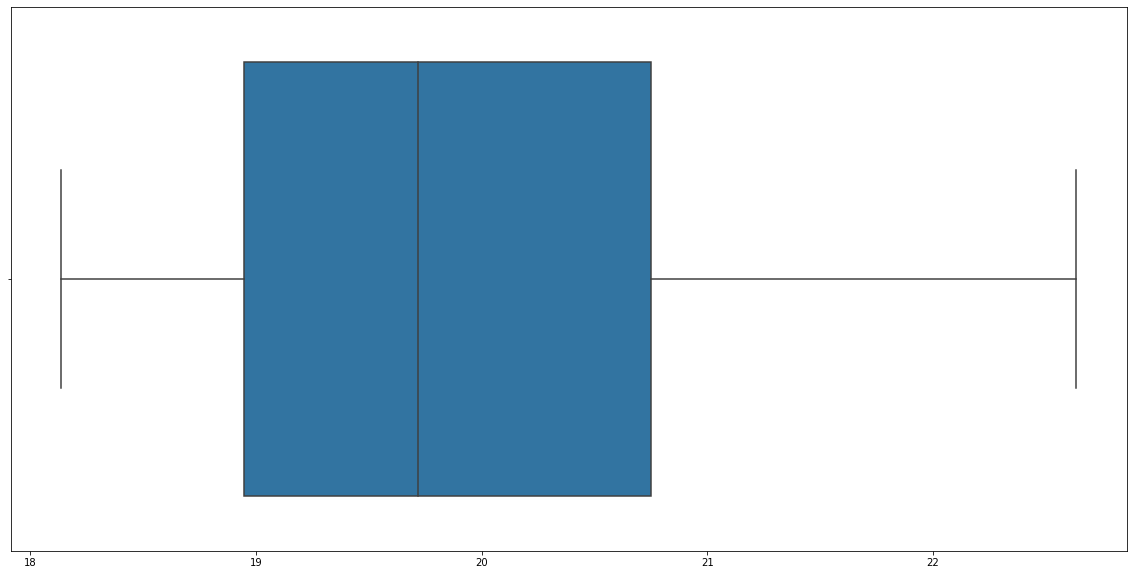

In [15]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.boxplot(data_std)

Text(0.5, 0, 'Time')

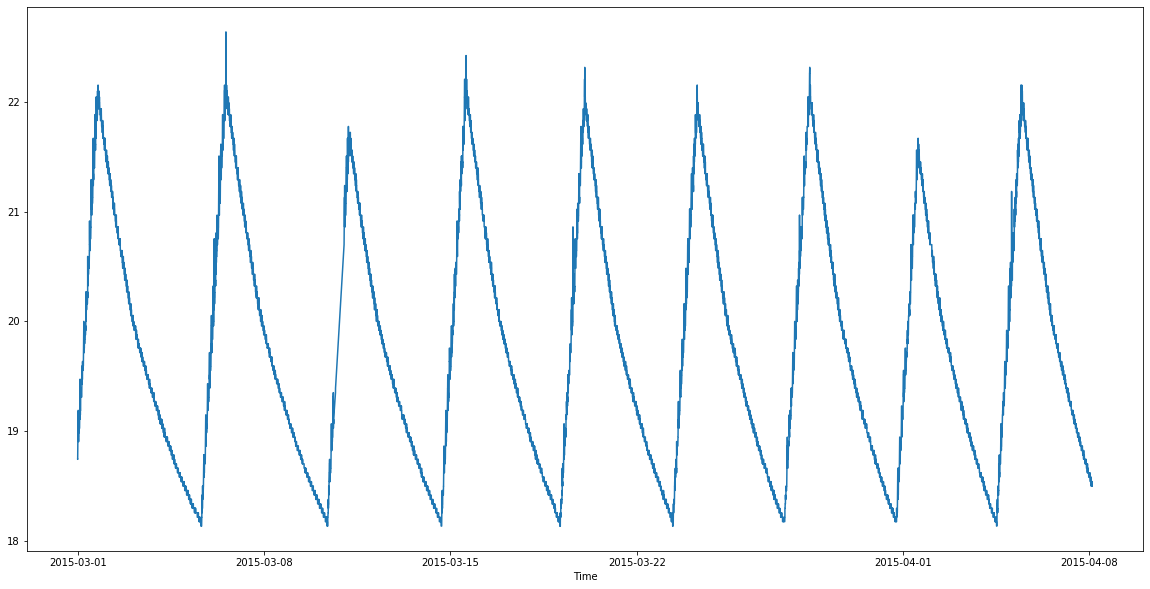

In [16]:
plt.figure(figsize=(20,10))
plt.plot(data_std)
plt.xlabel('Time')

In [17]:
data_pred = data_std.copy()

In [110]:
train = data_pred
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)

In [142]:
n_input =600
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=1)

In [143]:
train

array([[0.13505026],
       [0.13504159],
       [0.14405366],
       ...,
       [0.09003351],
       [0.09003351],
       [0.08103011]])

In [144]:
from tensorflow import keras

model = Sequential()
model.add(LSTM(200,return_sequences=True, activation='relu', input_shape=(n_input, n_features)))
model.add(LSTM(200, return_sequences= False))
model.add(Dropout(25))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(learning_rate=0.001) 
model.compile(optimizer=optimizer, loss='mse')

In [190]:
history = model.fit_generator(generator,epochs=1,verbose=1)

Epoch 1/1
   11/31517 [..............................] - ETA: 33:25:13 - loss: 2.3189e-04

KeyboardInterrupt: 

NameError: name 'ww' is not defined

In [129]:
pred_list = []
batch = train[-n_input:].reshape((1, n_input, n_features))

In [130]:
batch.shape

(1, 60, 1)

In [131]:
batch[0]

array([[0.0990369 ],
       [0.0990369 ],
       [0.0990369 ],
       [0.0990369 ],
       [0.0990369 ],
       [0.0990369 ],
       [0.0990369 ],
       [0.0990369 ],
       [0.0990369 ],
       [0.09003351],
       [0.09003351],
       [0.09003351],
       [0.09003351],
       [0.09003351],
       [0.09003351],
       [0.09003351],
       [0.09003351],
       [0.09003351],
       [0.0990369 ],
       [0.09003351],
       [0.09003351],
       [0.09003351],
       [0.09003351],
       [0.09003351],
       [0.09003351],
       [0.09003351],
       [0.09003351],
       [0.09003351],
       [0.08103011],
       [0.08103011],
       [0.08103011],
       [0.09003351],
       [0.09003351],
       [0.0990369 ],
       [0.09003351],
       [0.09003351],
       [0.09003351],
       [0.09003351],
       [0.09003351],
       [0.09003351],
       [0.09003351],
       [0.09003351],
       [0.09003351],
       [0.08103011],
       [0.08103011],
       [0.09003351],
       [0.09003351],
       [0.090

In [101]:
type(batch)

numpy.ndarray

In [136]:
n_pred  = 3000

In [137]:
for i in range(n_pred):
    print('----------------------------------------------------')
    pred_list.append(model.predict(batch)[0]) 
    print(pred_list)
#     print(pred_list.shape)
    print('----------------------------------------------------')
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)
#     print(batch)
#     print(batch.shape)
#     print('----------------------------------------------------')

----------------------------------------------------
[array([0.06205556], dtype=float32), array([0.06205556], dtype=float32), array([0.04130334], dtype=float32), array([0.04131284], dtype=float32), array([0.01933932], dtype=float32), array([0.01969904], dtype=float32), array([-0.00179759], dtype=float32)]
----------------------------------------------------
----------------------------------------------------
[array([0.06205556], dtype=float32), array([0.06205556], dtype=float32), array([0.04130334], dtype=float32), array([0.04131284], dtype=float32), array([0.01933932], dtype=float32), array([0.01969904], dtype=float32), array([-0.00179759], dtype=float32), array([0.04332349], dtype=float32)]
----------------------------------------------------
----------------------------------------------------
[array([0.06205556], dtype=float32), array([0.06205556], dtype=float32), array([0.04130334], dtype=float32), array([0.04131284], dtype=float32), array([0.01933932], dtype=float32), array([0.0

[array([0.06205556], dtype=float32), array([0.06205556], dtype=float32), array([0.04130334], dtype=float32), array([0.04131284], dtype=float32), array([0.01933932], dtype=float32), array([0.01969904], dtype=float32), array([-0.00179759], dtype=float32), array([0.04332349], dtype=float32), array([0.03644708], dtype=float32), array([0.02225569], dtype=float32), array([0.01972672], dtype=float32), array([-0.00089967], dtype=float32), array([-0.00220227], dtype=float32), array([-0.02131385], dtype=float32), array([0.02119991], dtype=float32), array([0.01102], dtype=float32), array([0.00434637], dtype=float32), array([-0.00291279], dtype=float32), array([-0.02023441], dtype=float32), array([-0.02495113], dtype=float32), array([-0.04015064], dtype=float32), array([-0.00603101], dtype=float32), array([-0.01389101], dtype=float32), array([-0.01444542], dtype=float32), array([-0.0247674], dtype=float32), array([-0.03883457], dtype=float32), array([-0.04729915], dtype=float32), array([-0.0590209

[array([0.06205556], dtype=float32), array([0.06205556], dtype=float32), array([0.04130334], dtype=float32), array([0.04131284], dtype=float32), array([0.01933932], dtype=float32), array([0.01969904], dtype=float32), array([-0.00179759], dtype=float32), array([0.04332349], dtype=float32), array([0.03644708], dtype=float32), array([0.02225569], dtype=float32), array([0.01972672], dtype=float32), array([-0.00089967], dtype=float32), array([-0.00220227], dtype=float32), array([-0.02131385], dtype=float32), array([0.02119991], dtype=float32), array([0.01102], dtype=float32), array([0.00434637], dtype=float32), array([-0.00291279], dtype=float32), array([-0.02023441], dtype=float32), array([-0.02495113], dtype=float32), array([-0.04015064], dtype=float32), array([-0.00603101], dtype=float32), array([-0.01389101], dtype=float32), array([-0.01444542], dtype=float32), array([-0.0247674], dtype=float32), array([-0.03883457], dtype=float32), array([-0.04729915], dtype=float32), array([-0.0590209

[array([0.06205556], dtype=float32), array([0.06205556], dtype=float32), array([0.04130334], dtype=float32), array([0.04131284], dtype=float32), array([0.01933932], dtype=float32), array([0.01969904], dtype=float32), array([-0.00179759], dtype=float32), array([0.04332349], dtype=float32), array([0.03644708], dtype=float32), array([0.02225569], dtype=float32), array([0.01972672], dtype=float32), array([-0.00089967], dtype=float32), array([-0.00220227], dtype=float32), array([-0.02131385], dtype=float32), array([0.02119991], dtype=float32), array([0.01102], dtype=float32), array([0.00434637], dtype=float32), array([-0.00291279], dtype=float32), array([-0.02023441], dtype=float32), array([-0.02495113], dtype=float32), array([-0.04015064], dtype=float32), array([-0.00603101], dtype=float32), array([-0.01389101], dtype=float32), array([-0.01444542], dtype=float32), array([-0.0247674], dtype=float32), array([-0.03883457], dtype=float32), array([-0.04729915], dtype=float32), array([-0.0590209

----------------------------------------------------
[array([0.06205556], dtype=float32), array([0.06205556], dtype=float32), array([0.04130334], dtype=float32), array([0.04131284], dtype=float32), array([0.01933932], dtype=float32), array([0.01969904], dtype=float32), array([-0.00179759], dtype=float32), array([0.04332349], dtype=float32), array([0.03644708], dtype=float32), array([0.02225569], dtype=float32), array([0.01972672], dtype=float32), array([-0.00089967], dtype=float32), array([-0.00220227], dtype=float32), array([-0.02131385], dtype=float32), array([0.02119991], dtype=float32), array([0.01102], dtype=float32), array([0.00434637], dtype=float32), array([-0.00291279], dtype=float32), array([-0.02023441], dtype=float32), array([-0.02495113], dtype=float32), array([-0.04015064], dtype=float32), array([-0.00603101], dtype=float32), array([-0.01389101], dtype=float32), array([-0.01444542], dtype=float32), array([-0.0247674], dtype=float32), array([-0.03883457], dtype=float32), a

[array([0.06205556], dtype=float32), array([0.06205556], dtype=float32), array([0.04130334], dtype=float32), array([0.04131284], dtype=float32), array([0.01933932], dtype=float32), array([0.01969904], dtype=float32), array([-0.00179759], dtype=float32), array([0.04332349], dtype=float32), array([0.03644708], dtype=float32), array([0.02225569], dtype=float32), array([0.01972672], dtype=float32), array([-0.00089967], dtype=float32), array([-0.00220227], dtype=float32), array([-0.02131385], dtype=float32), array([0.02119991], dtype=float32), array([0.01102], dtype=float32), array([0.00434637], dtype=float32), array([-0.00291279], dtype=float32), array([-0.02023441], dtype=float32), array([-0.02495113], dtype=float32), array([-0.04015064], dtype=float32), array([-0.00603101], dtype=float32), array([-0.01389101], dtype=float32), array([-0.01444542], dtype=float32), array([-0.0247674], dtype=float32), array([-0.03883457], dtype=float32), array([-0.04729915], dtype=float32), array([-0.0590209

[array([0.06205556], dtype=float32), array([0.06205556], dtype=float32), array([0.04130334], dtype=float32), array([0.04131284], dtype=float32), array([0.01933932], dtype=float32), array([0.01969904], dtype=float32), array([-0.00179759], dtype=float32), array([0.04332349], dtype=float32), array([0.03644708], dtype=float32), array([0.02225569], dtype=float32), array([0.01972672], dtype=float32), array([-0.00089967], dtype=float32), array([-0.00220227], dtype=float32), array([-0.02131385], dtype=float32), array([0.02119991], dtype=float32), array([0.01102], dtype=float32), array([0.00434637], dtype=float32), array([-0.00291279], dtype=float32), array([-0.02023441], dtype=float32), array([-0.02495113], dtype=float32), array([-0.04015064], dtype=float32), array([-0.00603101], dtype=float32), array([-0.01389101], dtype=float32), array([-0.01444542], dtype=float32), array([-0.0247674], dtype=float32), array([-0.03883457], dtype=float32), array([-0.04729915], dtype=float32), array([-0.0590209

[array([0.06205556], dtype=float32), array([0.06205556], dtype=float32), array([0.04130334], dtype=float32), array([0.04131284], dtype=float32), array([0.01933932], dtype=float32), array([0.01969904], dtype=float32), array([-0.00179759], dtype=float32), array([0.04332349], dtype=float32), array([0.03644708], dtype=float32), array([0.02225569], dtype=float32), array([0.01972672], dtype=float32), array([-0.00089967], dtype=float32), array([-0.00220227], dtype=float32), array([-0.02131385], dtype=float32), array([0.02119991], dtype=float32), array([0.01102], dtype=float32), array([0.00434637], dtype=float32), array([-0.00291279], dtype=float32), array([-0.02023441], dtype=float32), array([-0.02495113], dtype=float32), array([-0.04015064], dtype=float32), array([-0.00603101], dtype=float32), array([-0.01389101], dtype=float32), array([-0.01444542], dtype=float32), array([-0.0247674], dtype=float32), array([-0.03883457], dtype=float32), array([-0.04729915], dtype=float32), array([-0.0590209

----------------------------------------------------
[array([0.06205556], dtype=float32), array([0.06205556], dtype=float32), array([0.04130334], dtype=float32), array([0.04131284], dtype=float32), array([0.01933932], dtype=float32), array([0.01969904], dtype=float32), array([-0.00179759], dtype=float32), array([0.04332349], dtype=float32), array([0.03644708], dtype=float32), array([0.02225569], dtype=float32), array([0.01972672], dtype=float32), array([-0.00089967], dtype=float32), array([-0.00220227], dtype=float32), array([-0.02131385], dtype=float32), array([0.02119991], dtype=float32), array([0.01102], dtype=float32), array([0.00434637], dtype=float32), array([-0.00291279], dtype=float32), array([-0.02023441], dtype=float32), array([-0.02495113], dtype=float32), array([-0.04015064], dtype=float32), array([-0.00603101], dtype=float32), array([-0.01389101], dtype=float32), array([-0.01444542], dtype=float32), array([-0.0247674], dtype=float32), array([-0.03883457], dtype=float32), a

[array([0.06205556], dtype=float32), array([0.06205556], dtype=float32), array([0.04130334], dtype=float32), array([0.04131284], dtype=float32), array([0.01933932], dtype=float32), array([0.01969904], dtype=float32), array([-0.00179759], dtype=float32), array([0.04332349], dtype=float32), array([0.03644708], dtype=float32), array([0.02225569], dtype=float32), array([0.01972672], dtype=float32), array([-0.00089967], dtype=float32), array([-0.00220227], dtype=float32), array([-0.02131385], dtype=float32), array([0.02119991], dtype=float32), array([0.01102], dtype=float32), array([0.00434637], dtype=float32), array([-0.00291279], dtype=float32), array([-0.02023441], dtype=float32), array([-0.02495113], dtype=float32), array([-0.04015064], dtype=float32), array([-0.00603101], dtype=float32), array([-0.01389101], dtype=float32), array([-0.01444542], dtype=float32), array([-0.0247674], dtype=float32), array([-0.03883457], dtype=float32), array([-0.04729915], dtype=float32), array([-0.0590209

In [138]:
type(pred_list)

list

In [140]:
pred_list = np.array(pred_list) 
pred_list

array([[ 0.06205556],
       [ 0.06205556],
       [ 0.04130334],
       [ 0.04131284],
       [ 0.01933932],
       [ 0.01969904],
       [-0.00179759],
       [ 0.04332349],
       [ 0.03644708],
       [ 0.02225569],
       [ 0.01972672],
       [-0.00089967],
       [-0.00220227],
       [-0.02131385],
       [ 0.02119991],
       [ 0.01102   ],
       [ 0.00434637],
       [-0.00291279],
       [-0.02023441],
       [-0.02495113],
       [-0.04015064],
       [-0.00603101],
       [-0.01389101],
       [-0.01444542],
       [-0.0247674 ],
       [-0.03883457],
       [-0.04729915],
       [-0.05902094],
       [-0.03812152],
       [-0.03943262],
       [-0.03673533],
       [-0.04544464],
       [-0.05676198],
       [-0.06668243],
       [-0.07705346],
       [-0.07028565],
       [-0.06682429],
       [-0.06342396],
       [-0.06713709],
       [-0.07563689],
       [-0.083902  ],
       [-0.09350514],
       [-0.09614918],
       [-0.09387887],
       [-0.09115234],
       [-0

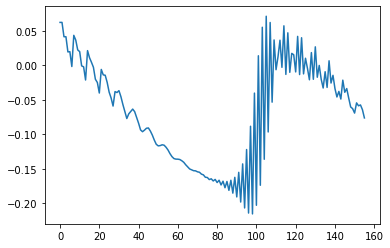

In [141]:
plt.plot(pred_list)

In [35]:
batch.shape

(1, 60, 1)

In [ ]:
from pandas.tseries.offsets import DateOffset

numPredict =9000
add_dates = [data_std.index[-1] + DateOffset(minutes=x) for x in range(0,numPredict,2) ]

In [ ]:
type(add_dates)

In [ ]:
add_dates[-10:]

In [ ]:
add_dates[:10]

In [ ]:
future_dates = pd.DataFrame(index=add_dates[1:],columns=data_std.columns)

In [ ]:
future_dates.tail(10)

In [ ]:
future_dates.shape

In [ ]:
pred_list

In [ ]:
r=0
for ii in pred_list:
    r=r+1
print(r)

In [ ]:
data_predict = pd.DataFrame(scaler.inverse_transform(pred_list), index=future_dates[-n_input:].index, columns=['Prediction'])

In [ ]:
data_predict

In [ ]:
data_predict.shape

In [ ]:
data_proj = pd.concat([data_std,data_predict], axis=1)

In [ ]:
pred_lists = []
fore_num = 


In [ ]:
data_std.head(50)

In [ ]:
data_std

In [ ]:
import datetime
from datetime import timedelta
 
datetimeFormat = '%Y-%m-%d %H:%M:%S.%f'
date1 = '2016-03-11 10:01:28.585'
date2 = '2016-03-10 09:56:28.067'
diff = datetime.datetime.strptime(date1, datetimeFormat) - datetime.datetime.strptime(date2, datetimeFormat)
 
print("Difference:", diff)
print("Days:", diff.days)
print("Microseconds:", diff.microseconds)
print("Seconds:", diff.seconds)

In [ ]:
df_std = data_std.copy()

In [ ]:
df=df.reset_index().head(10)

In [ ]:
df['StandardTime'][0]

In [ ]:
type(df['StandardTime'][0])

In [ ]:
import pandas as pd
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
from datetime import date
 
 
date1 = pd.Series(pd.date_range('2012-1-1 12:00:00', periods=7, freq='M'))
date2 = pd.Series(pd.date_range('2013-3-11 21:45:00', periods=7, freq='W'))
 
df = pd.DataFrame(dict(Start_date = date1, End_date = date2))
print(df)

In [ ]:
df_std = df_std.reset_index().head(10)
df_std

In [ ]:
dif_time = df_std['StandardTime'][1]-df_std['StandardTime'][0]
print(dif_time)

In [ ]:
df_std.shape

In [ ]:
df=data_std.reset_index().head(10)
df

In [ ]:
df = pd.DataFrame(dict(Start_date =df_std['StandardTime'][2:]  , End_date = df_std['StandardTime'][2:] - df_std['StandardTime'][1:]))

In [ ]:
d_date

In [ ]:
df_std['StandardTime'][2:] - df_std['StandardTime'][1:]

In [ ]:
index.drop(df['StandardTime'][2:])

In [75]:
r=[]
for iii in range(100):
    
    r.append(iii)

In [76]:
type(iii)

int

In [83]:
r

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

In [87]:
t=np.asarray(r)

In [85]:
df.drop('0',axis=1,inplace=True)

AttributeError: 'list' object has no attribute 'drop'

In [88]:
t

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [91]:
df1=0

In [93]:
df1 = pd.DataFrame(t)

In [94]:
df1

,0
0,0
1,1
2,2
3,3
4,4
...,...
95,95
96,96
97,97
98,98


In [95]:
t=df1.values

In [96]:
t

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29],
       [30],
       [31],
       [32],
       [33],
       [34],
       [35],
       [36],
       [37],
       [38],
       [39],
       [40],
       [41],
       [42],
       [43],
       [44],
       [45],
       [46],
       [47],
       [48],
       [49],
       [50],
       [51],
       [52],
       [53],
       [54],
       [55],
       [56],
       [57],
       [58],
       [59],
       [60],
       [61],
       [62],
       [63],
       [64],
       [65],
       [66],
       [67],
       [68],
       [69],
       [70],
       [71],
       [72],
       [73],
       [74],
       [75],
       [76],

In [105]:
t.shape

(100, 1)

In [97]:
x_t =[]
y_t = []
for i in range(20, len(t)):
    x_t.append(t[i-20:i, 0])
    y_t.append(t[i,0])

In [98]:
x_t

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20]),
 array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21]),
 array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22]),
 array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
        21, 22, 23]),
 array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24]),
 array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
        23, 24, 25]),
 array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
        24, 25, 26]),
 array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
        25, 26, 27]),
 array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
        26, 27, 28]),
 array([10, 11, 12, 

In [100]:
type(x_t)

list

In [107]:
x_t1, y_t1 = np.array(x_t), np.array(y_t)

In [103]:
x_t1

array([[ 0,  1,  2, ..., 17, 18, 19],
       [ 1,  2,  3, ..., 18, 19, 20],
       [ 2,  3,  4, ..., 19, 20, 21],
       ...,
       [77, 78, 79, ..., 94, 95, 96],
       [78, 79, 80, ..., 95, 96, 97],
       [79, 80, 81, ..., 96, 97, 98]])

In [104]:
x_t1.shape

(80, 20)

In [108]:
y_t1

array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
       88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [109]:
y_t1.shape

(80,)

In [167]:
batch.shape

(1, 5, 1)

In [180]:
batch

array([[[0.08103011],
        [0.08103011],
        [0.09003351],
        [0.09003351],
        [0.08103011]]])

In [187]:
# pred_list=np.array(pred_list)
pred_list = [1,1,2]
pred_list=np.reshape(pred_list,(1,3,1))

In [179]:
pred_list

array([[[0]]])

In [182]:
[[pred_list[0]]]

[[array([[0]])]]

In [188]:
n_input=5
n_pred=10
pred_list = []
batch = train[-n_input:].reshape((1, n_input, n_features))
print(batch)
for i in range(n_pred):
    print('----------------------------------------------------')
#     pred_list.append(model.predict(batch)[0]) 
    pred_list.append(i) 
    pred_list=np.array(pred_list)
    pred_list=np.reshape(pred_list,(1,i+1,1))
    print(pred_list)
#     print(pred_list.shape)
    print('----------------------------------------------------')
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

[[[0.08103011]
  [0.08103011]
  [0.09003351]
  [0.09003351]
  [0.08103011]]]
----------------------------------------------------
[[[0]]]
----------------------------------------------------


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 4 dimension(s)

In [166]:
for i in range(n_pred):
    print('----------------------------------------------------')
    pred_list.append(model.predict(batch)[0]) 
    print(pred_list)
#     print(pred_list.shape)
    print('----------------------------------------------------')
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

----------------------------------------------------


ValueError: Error when checking input: expected lstm_15_input to have shape (600, 1) but got array with shape (5, 1)

In [158]:
p_list=[]
b=[0,0,0,0,0]
b = np.array(b)
b

array([0, 0, 0, 0, 0])